# Naive Bayes

Tutorial for the Naive Bayes classifier using scikit-learn. This example uses Pyktok data to classify TikTok videos as ads or non-ads.

Code based on tutorial from StackAbuse: https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/  

### 1. Preparing our data for the model

In [15]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [16]:
df = pd.read_csv('pyktok_ad_data.csv',
                   usecols=['video_id', 'suggested_words', 'video_description', 'video_is_ad'])

#### Preprocessing the data

In [17]:
df['video_is_ad'] = df.video_is_ad.map({False: 0, True: 1})

#merge the suggested_words and video_description columns
df['description'] = df['suggested_words'].combine_first(df['video_description'])

#lowercase and remove punctuation
df['description'] = df.description.map(lambda x: x.lower())
df['description'] = df.description.str.replace('[^\w\s]', '')

df.head()

,video_id,suggested_words,video_description,video_is_ad,description
0,7305500598084881706,"Cat Tunnel Bed, Cat Brush, cattok, pet products, Cats Of TikTok, tik tok shop, TikTok Shop Items, powder donut face pets, cat accessories, toothbrush cat",Diz and Dub bith love their cat donut from the tiktok shop! Get it before sale runs out! 😻 #fyp #foryou #petbrush #cattunnel #catcave #TikTokShop #catmom #catdad #catperson #smurfcat #PetsOfTikTok #catbed #catsoftiktok #petlover #catlover #happycat #save #foryoupage #catdonut #tiktokshopblackfriday #tiktokshopcybermonday,1,"cat tunnel bed, cat brush, cattok, pet products, cats of tiktok, tik tok shop, tiktok shop items, powder donut face pets, cat accessories, toothbrush cat"
1,7303242532790619422,"cider sweater dress, Sweater Dress, knitted sweater dress, knitted dress, cider dress, 2 piece knitted dress, dresses, Viral Dress TikTok, Dress Outfit, Fashion Dresses",this dress fits like a glove! so flattering & comfy! love that it is a 2 piece as well 🤍 @Cider #sweaterdress #knitteddress #viraldress #cider #shopcider #TikTokShopBlackFriday #tiktokshopcybermonday,1,"cider sweater dress, sweater dress, knitted sweater dress, knitted dress, cider dress, 2 piece knitted dress, dresses, viral dress tiktok, dress outfit, fashion dresses"
2,7285271361201687839,"homeika pet vacuum, dog grooming vacuum, tik tok shop, homeika vacuum, homeika, dog grooming, Pet Vacuum, Belgian Malinois, vacuums, Vacuum Cleaner Pets","Paw Patrol approves this message. 🐶🚔 RUN DONT WALK! @Homeika_Official, I love you. #obsessed #homeikaofficial #homeikavacuum #homeika #tiktokmademebuyit #petgrooming #k9softiktok #k9officer #k9handler #tiktokshop #shoporflop #pawpatrol #holidaysteals",1,"homeika pet vacuum, dog grooming vacuum, tik tok shop, homeika vacuum, homeika, dog grooming, pet vacuum, belgian malinois, vacuums, vacuum cleaner pets"
3,7301040085624016170,"Cat Water Fountain, stainless steel water fountain, Cat Fountain, stainless steel fountain, uah pet fountain, Cattok, Fountain, Cat Of Tiktok, Stainless Steel, pet products",Stainless steel water fountains are my favorite. Use code 'WHITEBEARD' for 20% off!! #cats #catsoftiktok #pets #petsoftiktok #tabbycats #tortoiseshellcats #catlover #catslover #cutecats #UAHPET #PetFountain,1,"cat water fountain, stainless steel water fountain, cat fountain, stainless steel fountain, uah pet fountain, cattok, fountain, cat of tiktok, stainless steel, pet products"
4,7310401556791217450,"lenovo gm2pro earbuds, lenovo earbuds, TikTok shop, lenovo, Headphones, gm2 pro, airpods, bluetooth earbuds, bluetooth earphones, Lenovo Headphones",Most insane deal I’ve ever seen #lenovo #gm2pro #lenovogm2pro #earbuds #bluetooth #music #bluetoothearphone #coolgadget #tiktokshopholidaysale #thinkplus,1,"lenovo gm2pro earbuds, lenovo earbuds, tiktok shop, lenovo, headphones, gm2 pro, airpods, bluetooth earbuds, bluetooth earphones, lenovo headphones"


In [18]:
df.shape

(110, 5)

#### Tokenize the descriptions into separate words using nltk

You will need to install the nltk library, if you don't have it:

In [13]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


***NOTE:***
The code below will open a dialog window to ask you to downlaod some packages. In that window, switch to the "Models" tab and choose "punkt" from the "Identifier" column. Click "Download" and it will install the necessary files to apply tokenization.

In [1]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [19]:
df['description'] = df['description'].apply(nltk.word_tokenize)

#### Perform word stemming

In [20]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
 
df['description'] = df['description'].apply(lambda x: [stemmer.stem(y) for y in x])
df.head()

,video_id,suggested_words,video_description,video_is_ad,description
0,7305500598084881706,"Cat Tunnel Bed, Cat Brush, cattok, pet products, Cats Of TikTok, tik tok shop, TikTok Shop Items, powder donut face pets, cat accessories, toothbrush cat",Diz and Dub bith love their cat donut from the tiktok shop! Get it before sale runs out! 😻 #fyp #foryou #petbrush #cattunnel #catcave #TikTokShop #catmom #catdad #catperson #smurfcat #PetsOfTikTok #catbed #catsoftiktok #petlover #catlover #happycat #save #foryoupage #catdonut #tiktokshopblackfriday #tiktokshopcybermonday,1,"[cat, tunnel, bed, ,, cat, brush, ,, cattok, ,, pet, product, ,, cat, of, tiktok, ,, tik, tok, shop, ,, tiktok, shop, item, ,, powder, donut, face, pet, ,, cat, accessori, ,, toothbrush, cat]"
1,7303242532790619422,"cider sweater dress, Sweater Dress, knitted sweater dress, knitted dress, cider dress, 2 piece knitted dress, dresses, Viral Dress TikTok, Dress Outfit, Fashion Dresses",this dress fits like a glove! so flattering & comfy! love that it is a 2 piece as well 🤍 @Cider #sweaterdress #knitteddress #viraldress #cider #shopcider #TikTokShopBlackFriday #tiktokshopcybermonday,1,"[cider, sweater, dress, ,, sweater, dress, ,, knit, sweater, dress, ,, knit, dress, ,, cider, dress, ,, 2, piec, knit, dress, ,, dress, ,, viral, dress, tiktok, ,, dress, outfit, ,, fashion, dress]"
2,7285271361201687839,"homeika pet vacuum, dog grooming vacuum, tik tok shop, homeika vacuum, homeika, dog grooming, Pet Vacuum, Belgian Malinois, vacuums, Vacuum Cleaner Pets","Paw Patrol approves this message. 🐶🚔 RUN DONT WALK! @Homeika_Official, I love you. #obsessed #homeikaofficial #homeikavacuum #homeika #tiktokmademebuyit #petgrooming #k9softiktok #k9officer #k9handler #tiktokshop #shoporflop #pawpatrol #holidaysteals",1,"[homeika, pet, vacuum, ,, dog, groom, vacuum, ,, tik, tok, shop, ,, homeika, vacuum, ,, homeika, ,, dog, groom, ,, pet, vacuum, ,, belgian, malinoi, ,, vacuum, ,, vacuum, cleaner, pet]"
3,7301040085624016170,"Cat Water Fountain, stainless steel water fountain, Cat Fountain, stainless steel fountain, uah pet fountain, Cattok, Fountain, Cat Of Tiktok, Stainless Steel, pet products",Stainless steel water fountains are my favorite. Use code 'WHITEBEARD' for 20% off!! #cats #catsoftiktok #pets #petsoftiktok #tabbycats #tortoiseshellcats #catlover #catslover #cutecats #UAHPET #PetFountain,1,"[cat, water, fountain, ,, stainless, steel, water, fountain, ,, cat, fountain, ,, stainless, steel, fountain, ,, uah, pet, fountain, ,, cattok, ,, fountain, ,, cat, of, tiktok, ,, stainless, steel, ,, pet, product]"
4,7310401556791217450,"lenovo gm2pro earbuds, lenovo earbuds, TikTok shop, lenovo, Headphones, gm2 pro, airpods, bluetooth earbuds, bluetooth earphones, Lenovo Headphones",Most insane deal I’ve ever seen #lenovo #gm2pro #lenovogm2pro #earbuds #bluetooth #music #bluetoothearphone #coolgadget #tiktokshopholidaysale #thinkplus,1,"[lenovo, gm2pro, earbud, ,, lenovo, earbud, ,, tiktok, shop, ,, lenovo, ,, headphon, ,, gm2, pro, ,, airpod, ,, bluetooth, earbud, ,, bluetooth, earphon, ,, lenovo, headphon]"


#### Use CountVectorizer to transform data into occurrences

In [21]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

# This converts the list of words into space-separated strings
df['description'] = df['description'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['description'])

#### Use TF-IDF as model features instead of word counts

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts = transformer.transform(counts)

### 2. Using the Naive Bayes Model

#### Split the data into training and testing sets

In [25]:
from sklearn.model_selection import train_test_split

shuffled_df = df.sample(frac=1, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(counts, shuffled_df['video_is_ad'], 
                                                    test_size=0.2, random_state=1)

#### Fit the data to a Naive Bayes classifier.

We use the Multinomial Naive Bayes Classifier here for text classification. There are other types of Naive Bayes classifiers for a variety of tasks.

In [26]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

#### Testing the model 

In [27]:
import numpy as np

predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.7272727272727273


Our model's accuracy varies between 60-75%, which isn't great...Let's check the number of features and the sparsity of the document-term matrix. 

In [28]:
import numpy as np

features = len(count_vect.get_feature_names_out())
print("Number of features:", features)

#Sparsity is the number of zero-valued elements divided by the total number of elements
sparsity = (1- np.count_nonzero(X_train.toarray()) / np.prod(X_train.shape)) * 100
print("Sparsity:", sparsity)


Number of features: 844
Sparsity: 98.36412106850496


We can use a confusion matrix to get a better idea of our model's performance:

### 3. Confusion Matrix Heatmap

In [29]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predicted)

Text(0.5, 1.0, 'Confusion Matrix for TikTok Ad Detection Model')

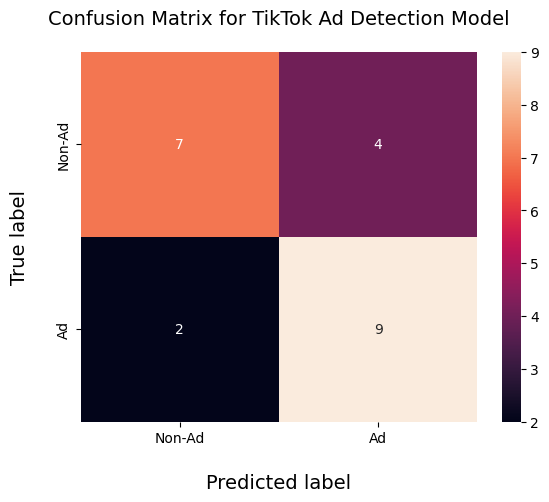

In [31]:
import seaborn as sns

# Plot confusion matrix
ax = sns.heatmap(conf_matrix, annot=True)
 
# set x-axis label and ticks. 
ax.set_xlabel("Predicted label", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Non-Ad', 'Ad'])
 
# set y-axis label and ticks
ax.set_ylabel("True label", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Non-Ad', 'Ad'])
 
# set plot title
ax.set_title("Confusion Matrix for TikTok Ad Detection Model", fontsize=14, pad=20)

In [32]:
# Let's print out the values for each cell in the confusion matrix:
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()
 
true_neg, false_pos, false_neg, true_pos

(7, 4, 2, 9)

**Calculate f1_score**

In [33]:
from sklearn.metrics import f1_score

f1_score(y_test.values, predicted, average='weighted')

0.725